# NE Climate Analysis Examples #
### Plotting Scripts ###

This notebook contains a collection of examples of analyses that can be done with the MWWavelets code.

### Contents
1. [Processing and Displaying Data](#Processing)
2. [Wavelets](#Wavelets)
3. [Plotting Wavelet Transform Coefficients](#Plotting)
4. [Wavelet Transforms on NEI Averaged Data](#NEI)
5. [Wavelet Transforms on Appalachian Sorted Data](#Appalachian)

In [1]:
# Scripts taken from: http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Importing%20Notebooks.html
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [2]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod
    
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

### Importing MWWavelets
Imports the methods required to apply the transforms. Also constructs the NE Climate database.

In [3]:
from MWWavelets_GitHub import *

importing Jupyter notebook from MWWavelets_GitHub.ipynb
checkpoint 1
checkpoint 2
Completed Initilization of Objects!
Finished adding coordinates and elevation to StateIDs!
Number of StateIDs West of Appalachians:  83
Number of StateIDs East of Appalachians:  54


<a id='Processing'></a>
# 1. Processing and Displaying Data
------------------------
Since matplotlib's default color scheme is awful, we will steal Tableau's default color scheme for some of the plots.

In [4]:
# from: http://www.randalolson.com/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/
# tableau's default color scheme
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

### Accessing data from a StateID object

In [5]:
# first few station IDs
print('First 5 Station IDs: {}'.format([i.name() for i in StateID_objects[0:5]]))

# USING THE select_id FUNCTION
#
# give it a station ID number and a list of station IDs, it will return the object
# with that station ID number
station_id = 62658
station_obj = select_id(station_id, StateID_objects)

print('')

# and now we can choose from max_temp, min_temp, and precip data 
max_temps_dict = station_obj.max_temp()
print('First 3 years of max temp data for {}:'.format(station_id))
for i in list(max_temps_dict.keys())[0:3]:
    print('{}: {}'.format(i, max_temps_dict[i]))

print('')

# the dict_to_list function turns this dictionary into a chronologically ordered list
max_temps = dict_to_list(max_temps_dict)
print('First 5 max temperature z-scores for {}: {}'.format(station_id, max_temps[0:5]))

First 5 Station IDs: [62658, 63207, 67970, 68138, 170100]

First 3 years of max temp data for 62658:
1900: [0.749828083, 0.269465237, -0.987106505, -0.124029808, 0.092558745, 0.519263856, -0.017507739, 1.008602476, 0.970725375, 0.658423553, 0.190288041, 0.271626603]
1901: [-0.100160859, -1.386466388, -0.467814428, -0.523135626, -0.850169212, 0.768112349, 0.651905808, -0.254971096, -0.027141992, -0.037444319, -2.078046217, -0.079831109]
1902: [-0.283942252, -0.558500575, 0.977172222, 0.336476905, -0.16454888, -0.890877606, -2.025748378, -0.841630254, -0.705691802, -0.600765929, 1.450473739, -0.958475388]

First 5 max temperature z-scores for 62658: [0.749828083, 0.269465237, -0.987106505, -0.124029808, 0.092558745]


### Example Time Series Plot

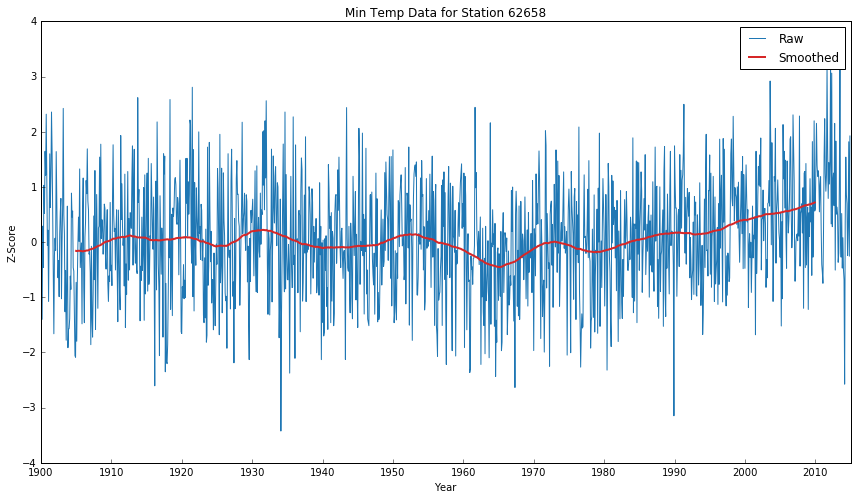

In [6]:
# plotting max temp data for 62658
N = 1380
x_val = np.linspace(1900, 2014+11.0/12, N, endpoint=True)
temps = dict_to_list(select_id(62658, StateID_objects).min_temp())

# smoothed min temp data
new_vals = gaussian_smoother(x_val, temps, 2.5)
smoothed_x_vals = new_vals[0]
smoothed_y_vals = new_vals[1]

plt.figure(figsize=(12, 7))

ax = plt.subplot(111)     
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 

plt.xlim(1900, 2015)
plt.xticks(np.arange(1900,2016,10))
plt.xlabel("Year")
plt.ylabel("Z-Score")
plt.title("Min Temp Data for Station 62658")

plt.plot(x_val, temps, color=tableau20[0])
plt.plot(smoothed_x_vals, smoothed_y_vals, color=tableau20[6], linewidth=2.0)
plt.legend(['Raw', 'Smoothed'])
plt.tight_layout()
plt.show()

### Index and Averaging Methods

Here we plot the average of each metric across all of the weather stations, and also plot the averaged NEI index from these metrics. The data is smoothed with a Gaussian envelope of width 5 years.

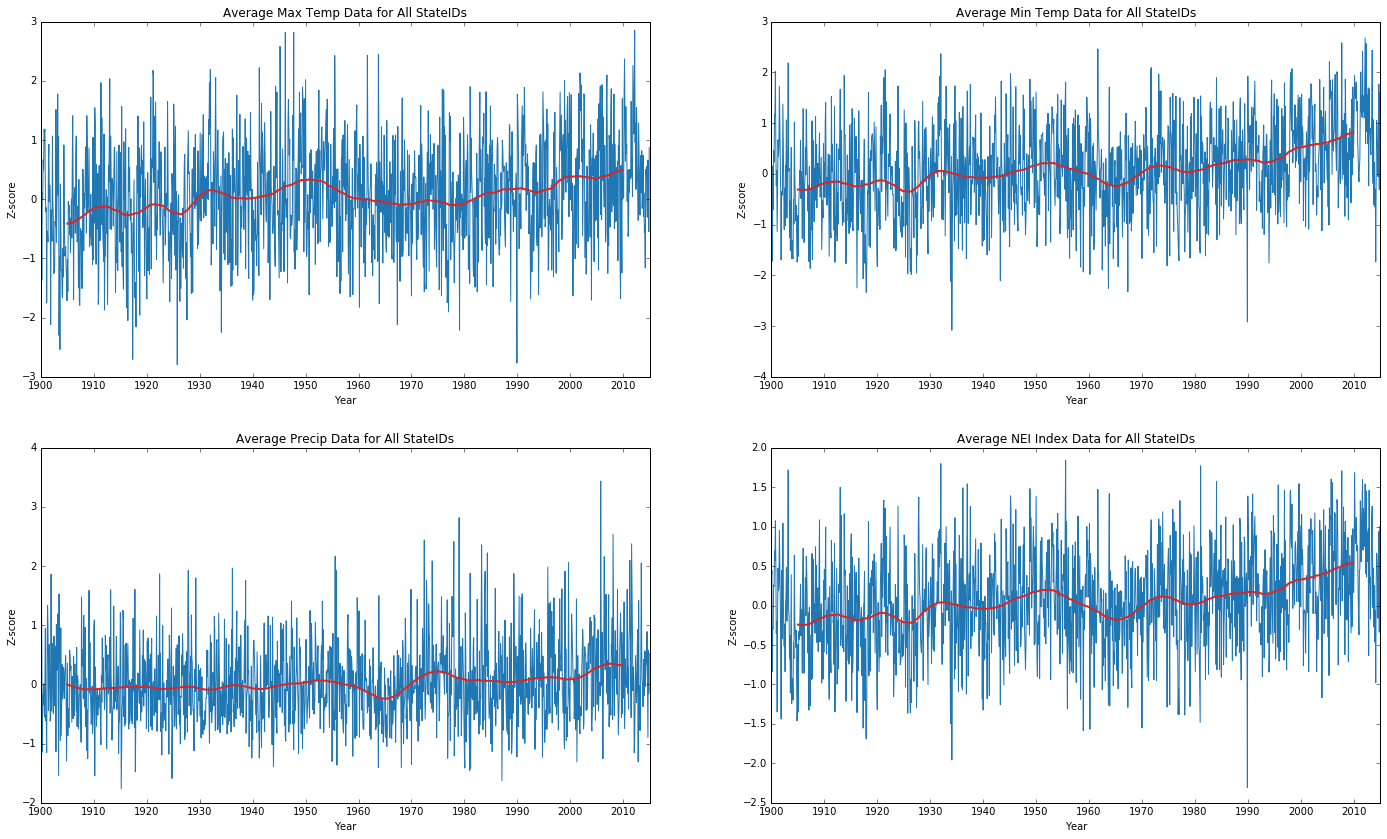

In [7]:
# averaging all stations together
N = 1380
x_val = np.linspace(1900, 2014+11.0/12, N, endpoint=True)
lists = average_StateID_series(StateID_objects)
avg_max_temps = lists[0]
smooth_max_temps_x, smooth_max_temps_y = gaussian_smoother(x_val, avg_max_temps, 2.5)
avg_min_temps = lists[1]
smooth_min_temps_x, smooth_min_temps_y = gaussian_smoother(x_val, avg_min_temps, 2.5)
avg_precips = lists[2]
smooth_precip_x, smooth_precip_y = gaussian_smoother(x_val, avg_precips, 2.5)
avg_nei = lists[3]
smooth_nei_x, smooth_nei_y = gaussian_smoother(x_val, avg_nei, 2.5)

plt.figure(figsize=(24,14))
plt.subplot(2, 2, 1)
plt.plot(x_val, avg_max_temps, color=tableau20[0])
plt.plot(smooth_max_temps_x, smooth_max_temps_y, color=tableau20[6], linewidth=2.0)
plt.xlim(1900, 2015)
plt.xticks(np.arange(1900, 2016, 10))
plt.xlabel("Year")
plt.ylabel("Z-score")
title_string_raw = "Average Max Temp Data for All StateIDs"
plt.title(title_string_raw)

plt.subplot(2, 2, 2)
plt.plot(x_val, avg_min_temps, color=tableau20[0])
plt.plot(smooth_min_temps_x, smooth_min_temps_y, color=tableau20[6], linewidth=2.0)
plt.xlim(1900, 2015)
plt.xticks(np.arange(1900, 2016, 10))
plt.xlabel("Year")
plt.ylabel("Z-score")
title_string_raw = "Average Min Temp Data for All StateIDs"
plt.title(title_string_raw)

plt.subplot(2, 2, 3)
plt.plot(x_val, avg_precips, color=tableau20[0])
plt.plot(smooth_precip_x, smooth_precip_y, color=tableau20[6], linewidth=2.0)
plt.xlim(1900, 2015)
plt.xticks(np.arange(1900, 2016, 10))
plt.xlabel("Year")
plt.ylabel("Z-score")
title_string_raw = "Average Precip Data for All StateIDs"
plt.title(title_string_raw)

plt.subplot(2, 2, 4)
plt.plot(x_val, avg_nei, color=tableau20[0])
plt.plot(smooth_nei_x, smooth_nei_y, color=tableau20[6], linewidth=2.0)
plt.xlim(1900, 2015)
plt.xticks(np.arange(1900, 2016, 10))
plt.xlabel("Year")
plt.ylabel("Z-score")
title_string_raw = "Average NEI Index Data for All StateIDs"
plt.title(title_string_raw)
plt.show()

<a id='Wavelets'></a>
# 2. Wavelets
--------------------------
Simple visualizations of the wavelet shapes used in the thesis.

### Sampled Morlet Wavelet Plot

Wavelet period-year conversion is: 0.9876458532208658
Number of required sampling points: 24.0


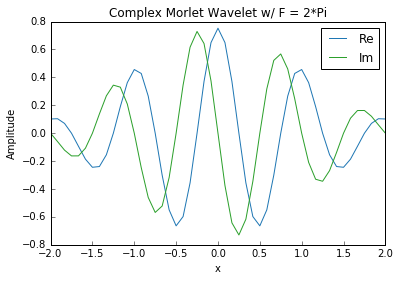

In [8]:
# plotting sampled Morlet wavelet
mlt = Morlet_Wavelet(1, 2*np.pi)
x = np.linspace(-2, 2, 2*mlt.sampling_points()+1)
y = np.real(mlt.morlet_function())
z = np.imag(mlt.morlet_function())
print("Wavelet period-year conversion is: {}".format(mlt.scale_to_year()))
print("Number of required sampling points: {}".format(mlt.sampling_points()))

plt.figure()
ax = plt.subplot(111)     
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 
plt.xlim(-2, 2)
plt.xlabel("x")
plt.ylabel("Amplitude")
plt.title("Complex Morlet Wavelet w/ F = 2*Pi")

plt.plot(x, y, color=tableau20[0])
plt.plot(x, z, color=tableau20[4])
plt.legend(['Re','Im'])

plt.show()

### Sampled Harr Wavelet Plot

Harr wavelet width is (in years): 2


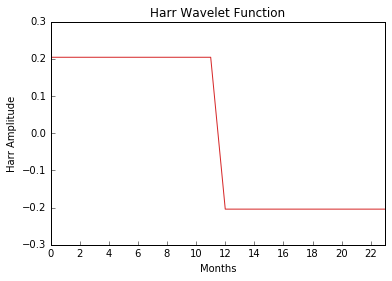

In [9]:
# plotting Harr wavelet
harr = Harr_Wavelet(2)
s = harr.scale()
x = np.linspace(0, 12*s-1, 12*s)
y = harr.harr_function()
print("Harr wavelet width is (in years): "+str(s))

plt.figure()
ax = plt.subplot(111)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.xlim(0, 12*s-1)
plt.xticks(np.arange(0, 12*s-1,2))
plt.xlabel("Months")
plt.ylabel("Harr Amplitude")
plt.title("Harr Wavelet Function")

plt.plot(x, y, color=tableau20[6])

plt.show()

<a id='Plotting'></a>
# 3. Plotting Wavelet Transform Coefficients
----------------------------
Here we look at the wavelet transform of the minimum temperature metric from our weather station in part 1.

In [10]:
ID = 62658
N = 1380
kernel_std = 1.25
kernel_width = 4*kernel_std
temps = dict_to_list(select_id(ID, StateID_objects).min_temp())
x_list = np.linspace(1900, 2014+11.0/12, N, endpoint=True)
smoothed_temps = gaussian_smoother(x_list, temps, kernel_std)

# performing the wavelet transform
transform_coefficients = continuous_transform_morlet(temps, scale_range(0.5, 30), 2*np.pi)
transform_power = wavelet_power_spectra(transform_coefficients)
print('length of transform coefficients is: '+str(len(transform_coefficients)))
print('number of coefficients at lowest scale: '+str(len(transform_coefficients[0])))

# renormalizing wavelet power with sample variance
variance = sample_variance(temps)
normalized_powers = normalized_wavelet_power_spectra(transform_power, variance)

length of transform coefficients is: 119
number of coefficients at lowest scale: 1380


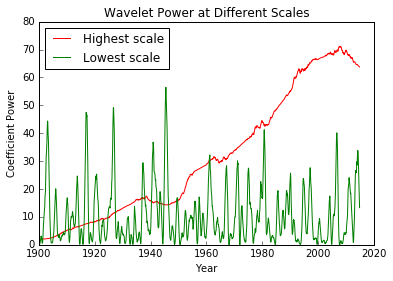

In [11]:
# plotting wavelet power at lowest and highest scale w.r.t time
N = 1380
X = np.linspace(1900, 2014+11/12, N, endpoint=True)
Y = transform_power[-1]
Z = transform_power[0]
plt.figure()
ax = plt.subplot(111)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.xlabel("Year")
plt.ylabel("Coefficient Power")
plt.title("Wavelet Power at Different Scales")
plt.plot(X, Y, '-r', X, Z, '-g')
plt.legend(['Highest scale', 'Lowest scale'], loc=2)
plt.show()

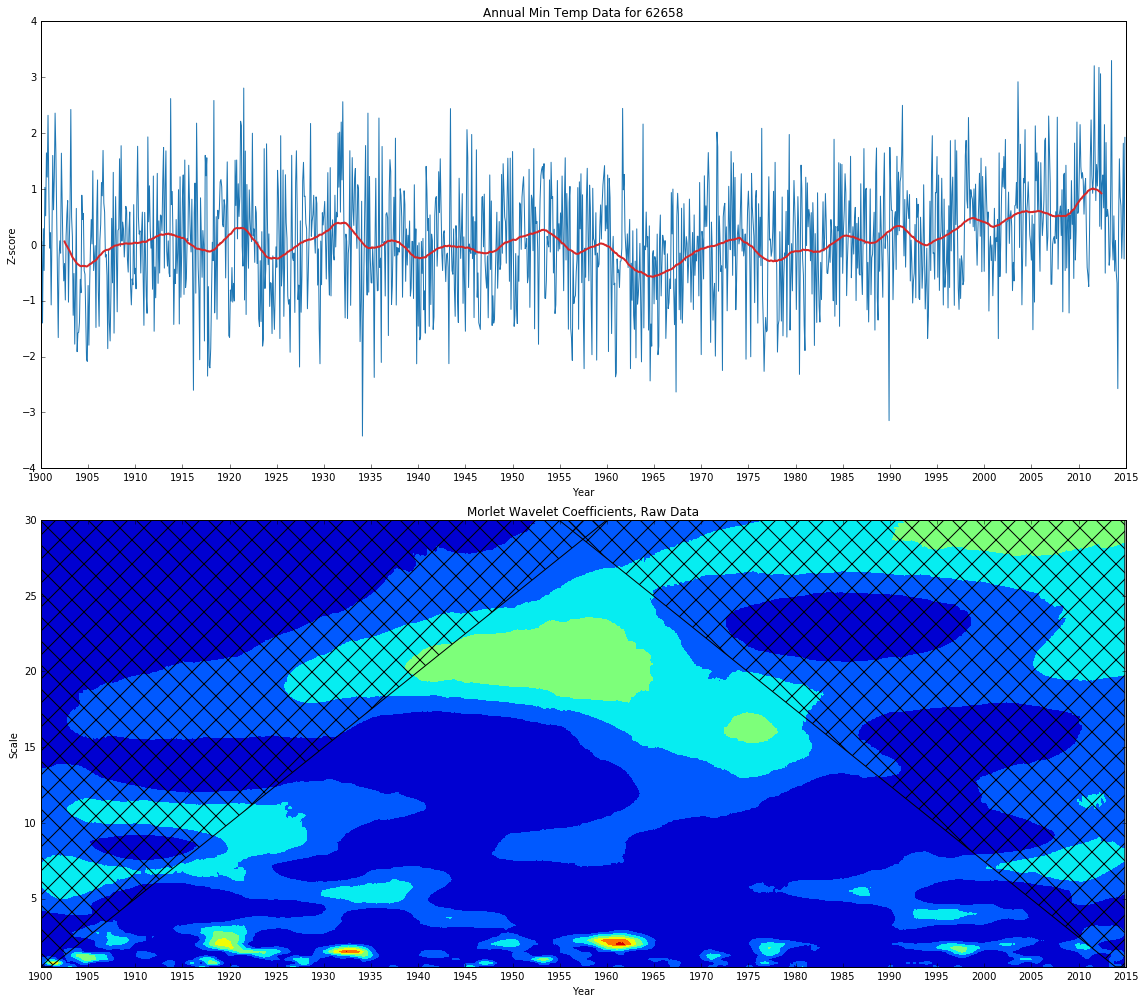

In [12]:
# plotting coefficients
N = 1380
X = np.linspace(1900, 2014+11/12, N, endpoint=True)
Y = scale_range(0.5, 30)
Z = transform_power

plt.figure(figsize=(16,14))
ax1 = plt.subplot(2, 1, 1)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
plt.plot(X, temps, color=tableau20[0])
plt.plot(smoothed_temps[0], smoothed_temps[1], color=tableau20[6], linewidth=2.0)
plt.xlim(1900, 2015)
plt.xticks(np.arange(1900, 2016, 5))
plt.xlabel("Year")
plt.ylabel("Z-score")
title_string_raw = "Annual Min Temp Data for " + str(ID)
plt.title(title_string_raw)

ax2 = plt.subplot(2, 1, 2)
# cone of influence
coi_left_coords = coi_left(X[0], Y)
coi_right_coords = coi_right(X[-1], Y)
ax2.add_patch(Polygon(coi_left_coords, closed=True,fill=False,hatch='x'))
ax2.add_patch(Polygon(coi_right_coords, closed=True,fill=False,hatch='x'))

plt.contourf(X, Y, Z)
plt.xticks(np.arange(1900, 2016, 5))
plt.xlabel("Year")
plt.ylabel("Scale")
plt.title("Morlet Wavelet Coefficients, Raw Data")
#cbar = plt.colorbar()

plt.tight_layout()
plt.show()

<a id='NEI'></a>
# 4. Wavelet Transforms on NEI Averaged Data
------------------------------
We now look at the wavelet transforms for each metric averaged across all of the stations in our database.

In [13]:
# names of data sets for all Northeast averaged data:
# avg_nei, avg_max_temps, avg_min_temps, avg_precips
kernel_std = 1.25
kernel_width = 4*kernel_std
scales = scale_range(0.5, 25)
nei_years = scale_range_years(scales, 2*np.pi)
x_list = np.linspace(1900, 2014+11.0/12, 1380, endpoint=True)

# Max Temp data
maxt_transform_coeff = continuous_transform_morlet(avg_max_temps, scales, 2*np.pi)
maxt_transform_power = wavelet_power_spectra(maxt_transform_coeff)

maxt_smooth_x, maxt_smooth_y = gaussian_smoother(x_list, avg_max_temps, kernel_std)

# Min Temp data
mint_transform_coeff = continuous_transform_morlet(avg_min_temps, scales, 2*np.pi)
mint_transform_power = wavelet_power_spectra(mint_transform_coeff)

mint_smooth_x, mint_smooth_y = gaussian_smoother(x_list, avg_min_temps, kernel_std)

# Precip data
precip_transform_coeff = continuous_transform_morlet(avg_precips, scales, 2*np.pi)
precip_transform_power = wavelet_power_spectra(precip_transform_coeff)

precip_smooth_x, precip_smooth_y = gaussian_smoother(x_list, avg_precips, kernel_std)

# NEI data
nei_transform_coeff = continuous_transform_morlet(avg_nei, scales, 2*np.pi)
nei_transform_power = wavelet_power_spectra(nei_transform_coeff)

nei_smooth_x, nei_smooth_y = gaussian_smoother(x_list, avg_nei, kernel_std)

coi_data_left = coi_left(x_list[0], nei_years)
coi_data_right = coi_right(x_list[-1], nei_years)

### Maximum Temperature Data

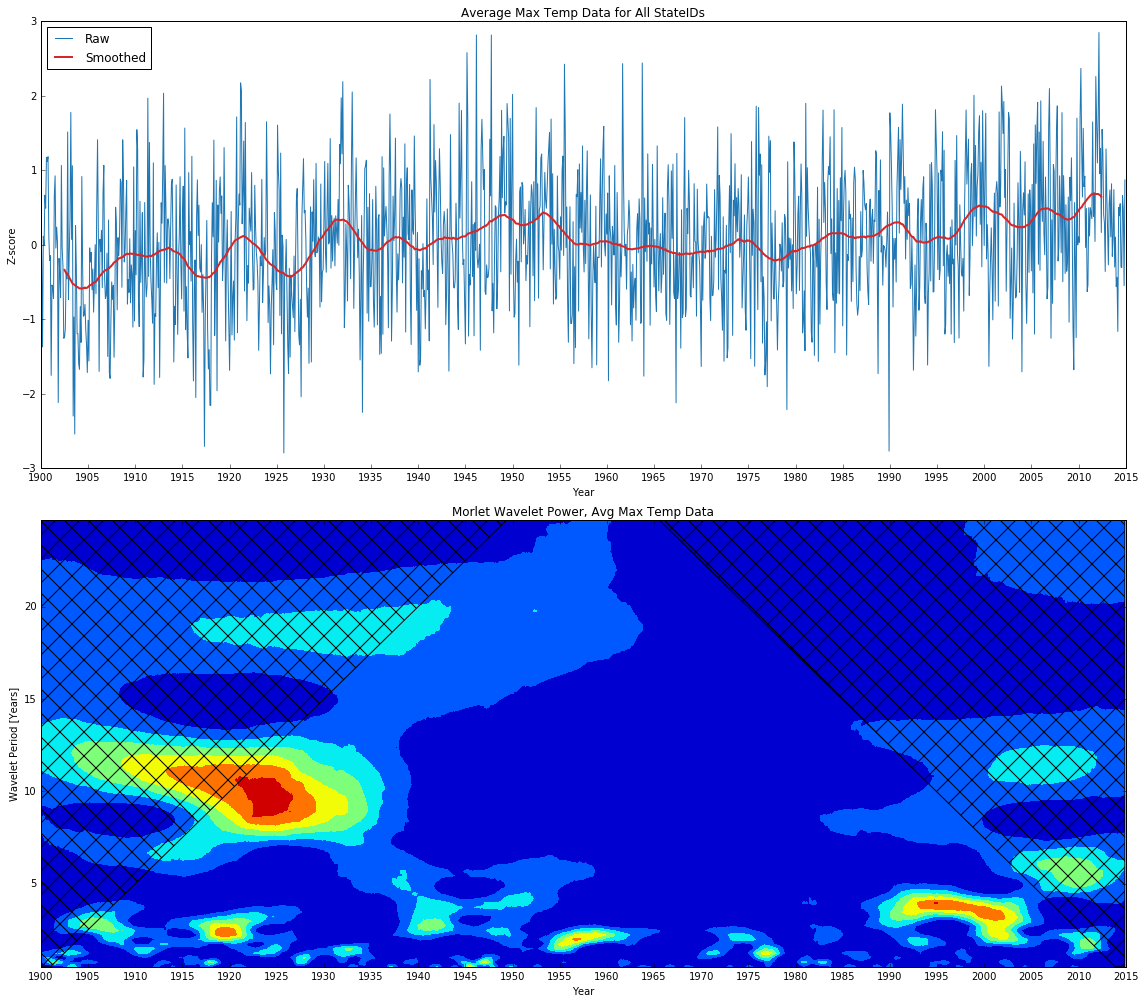

In [14]:
plt.figure(figsize=(16,14))
ax1 = plt.subplot(2, 1, 1)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
ax1.set_xlim(1900, 2015)
ax1.set_xticks(np.arange(1900, 2016, 5))
ax1.set_xlabel("Year")
ax1.set_ylabel("Z-score")
ax1.plot(x_list, avg_max_temps, color=tableau20[0])
ax1.plot(maxt_smooth_x, maxt_smooth_y, color=tableau20[6], linewidth=2.0)
ax1.legend(['Raw','Smoothed'],loc=2)
title_string_raw = "Average Max Temp Data for All StateIDs"
ax1.set_title(title_string_raw)

ax2 = plt.subplot(2, 1, 2)
ax2.contourf(x_list, nei_years, maxt_transform_power)
ax2.add_patch(Polygon(coi_data_left, closed=True,fill=False,hatch='x'))
ax2.add_patch(Polygon(coi_data_right, closed=True,fill=False,hatch='x'))
ax2.set_xticks(np.arange(1900, 2016, 5))
ax2.set_xlabel("Year")
ax2.set_ylabel("Wavelet Period [Years]")
ax2.set_title("Morlet Wavelet Power, Avg Max Temp Data")
plt.tight_layout()
plt.show()

### Minimum Temperature Data

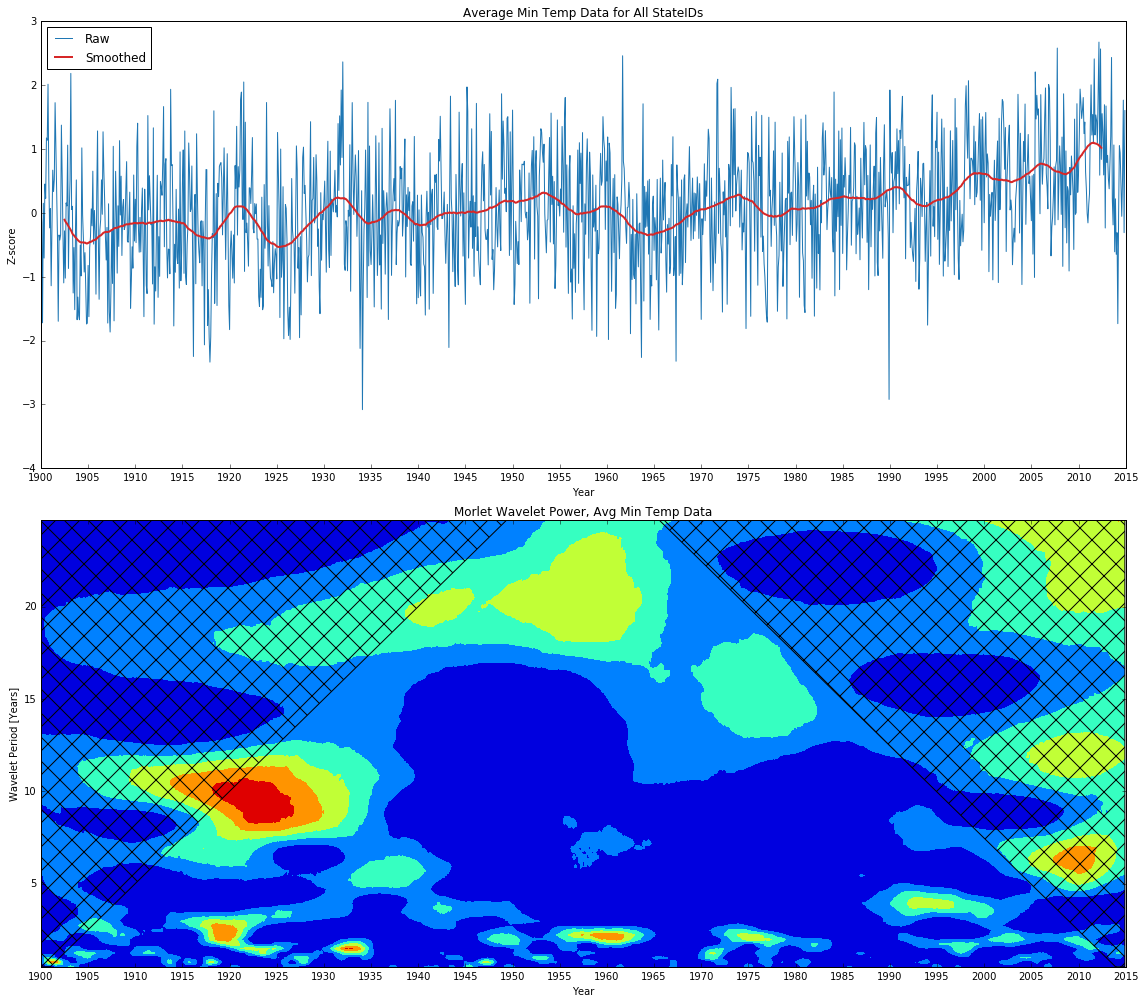

In [15]:
plt.figure(figsize=(16,14))
ax1 = plt.subplot(2, 1, 1)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
ax1.set_xlim(1900, 2015)
ax1.set_xticks(np.arange(1900, 2016, 5))
ax1.set_xlabel("Year")
ax1.set_ylabel("Z-score")
ax1.plot(x_list, avg_min_temps, color=tableau20[0])
ax1.plot(mint_smooth_x, mint_smooth_y, color=tableau20[6], linewidth=2.0)
ax1.legend(['Raw','Smoothed'],loc=2)
title_string_raw = "Average Min Temp Data for All StateIDs"
ax1.set_title(title_string_raw)

ax2 = plt.subplot(2, 1, 2)
ax2.contourf(x_list, nei_years, mint_transform_power)
ax2.add_patch(Polygon(coi_data_left, closed=True,fill=False,hatch='x'))
ax2.add_patch(Polygon(coi_data_right, closed=True,fill=False,hatch='x'))
ax2.set_xticks(np.arange(1900, 2016, 5))
ax2.set_xlabel("Year")
ax2.set_ylabel("Wavelet Period [Years]")
ax2.set_title("Morlet Wavelet Power, Avg Min Temp Data")
plt.tight_layout()
plt.show()

### Precipitation Data

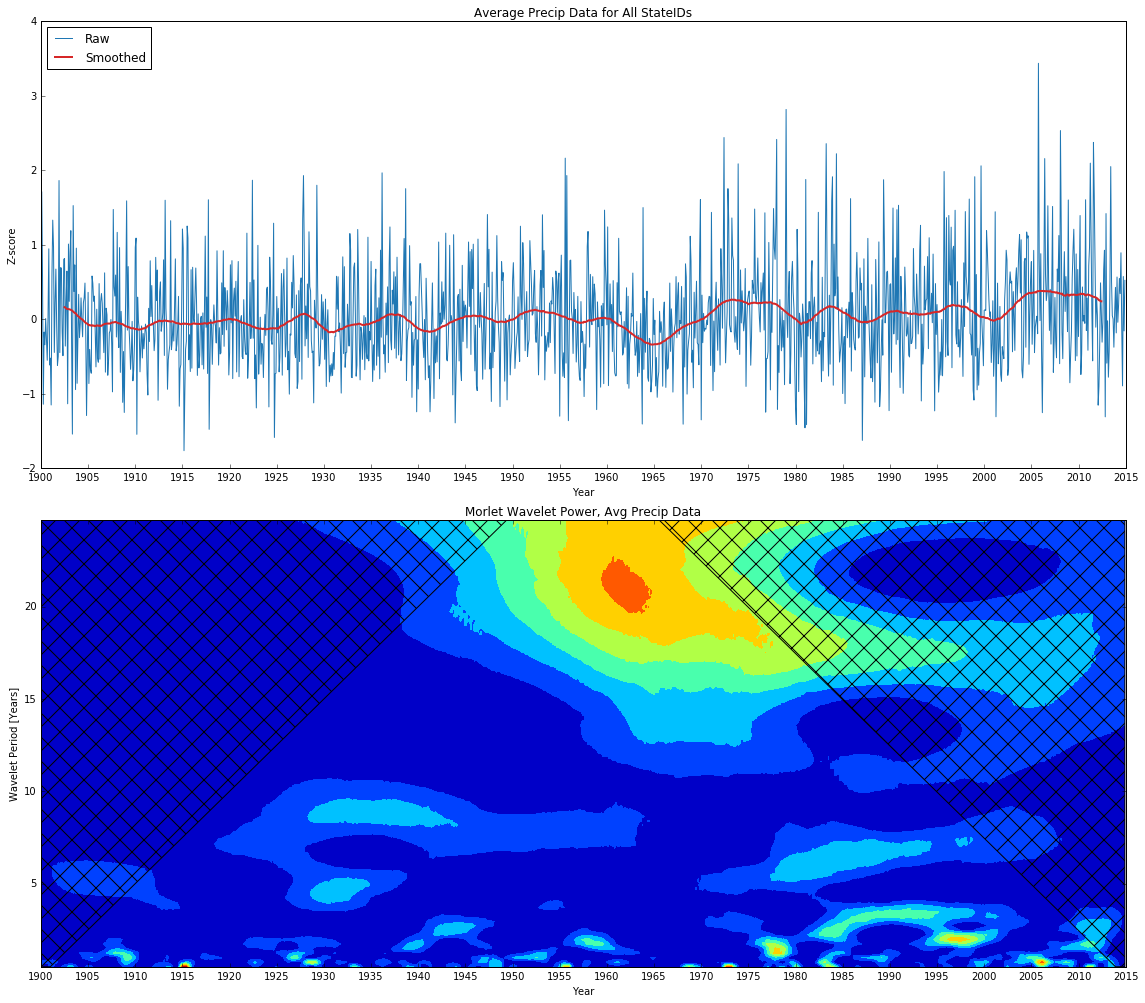

In [16]:
plt.figure(figsize=(16,14))
ax1 = plt.subplot(2, 1, 1)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
ax1.set_xlim(1900, 2015)
ax1.set_xticks(np.arange(1900, 2016, 5))
ax1.set_xlabel("Year")
ax1.set_ylabel("Z-score")
ax1.plot(x_list, avg_precips, color=tableau20[0])
ax1.plot(precip_smooth_x, precip_smooth_y, color=tableau20[6], linewidth=2.0)
ax1.legend(['Raw','Smoothed'],loc=2)
title_string_raw = "Average Precip Data for All StateIDs"
ax1.set_title(title_string_raw)

ax2 = plt.subplot(2, 1, 2)
ax2.contourf(x_list, nei_years, precip_transform_power)
ax2.add_patch(Polygon(coi_data_left, closed=True,fill=False,hatch='x'))
ax2.add_patch(Polygon(coi_data_right, closed=True,fill=False,hatch='x'))
ax2.set_xticks(np.arange(1900, 2016, 5))
ax2.set_xlabel("Year")
ax2.set_ylabel("Wavelet Period [Years]")
ax2.set_title("Morlet Wavelet Power, Avg Precip Data")
plt.tight_layout()
plt.show()

### NEI Data

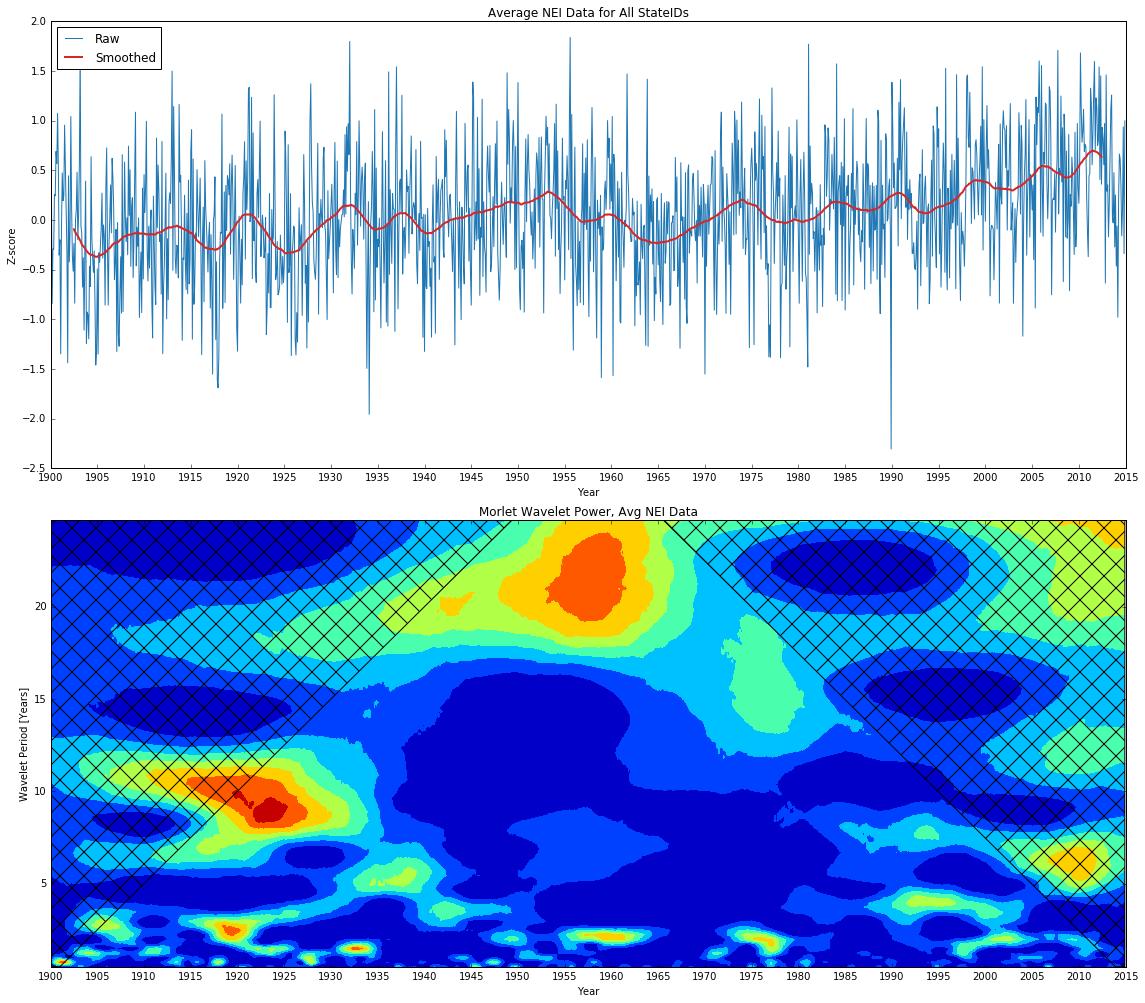

In [17]:
plt.figure(figsize=(16,14))
ax1 = plt.subplot(2, 1, 1)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
ax1.set_xlim(1900, 2015)
ax1.set_xticks(np.arange(1900, 2016, 5))
ax1.set_xlabel("Year")
ax1.set_ylabel("Z-score")
ax1.plot(x_list, avg_nei, color=tableau20[0])
ax1.plot(nei_smooth_x, nei_smooth_y, color=tableau20[6], linewidth=2.0)
ax1.legend(['Raw','Smoothed'],loc=2)
title_string_raw = "Average NEI Data for All StateIDs"
ax1.set_title(title_string_raw)

ax2 = plt.subplot(2, 1, 2)
ax2.contourf(x_list, nei_years, nei_transform_power)
ax2.add_patch(Polygon(coi_data_left, closed=True,fill=False,hatch='x'))
ax2.add_patch(Polygon(coi_data_right, closed=True,fill=False,hatch='x'))
ax2.set_xticks(np.arange(1900, 2016, 5))
ax2.set_xlabel("Year")
ax2.set_ylabel("Wavelet Period [Years]")
ax2.set_title("Morlet Wavelet Power, Avg NEI Data")
plt.tight_layout()
plt.show()

<a id='Appalachian'></a>
# 5. Wavelet Transform on Appalachian Sorted Data
----------------------------
We were interested in investigating if the data to the west of the Appalachian mountains showed a regional difference from the data to the east of the Appalachians.

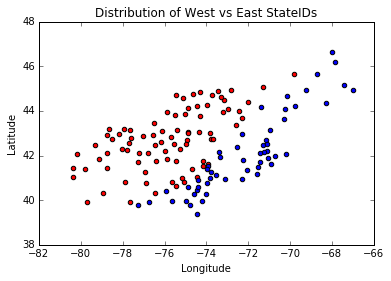

In [18]:
# compiling data for plotting all parameters
# west data
west_stations = Appalachian_StateID_objects[0]
west_data = average_StateID_series(west_stations)
west_maxtemp_data = west_data[0]
west_mintemp_data = west_data[1]
west_precip_data = west_data[2]
west_nei_data = west_data[3]

# east data
east_stations = Appalachian_StateID_objects[1]
east_data = average_StateID_series(east_stations)
east_maxtemp_data = east_data[0]
east_mintemp_data = east_data[1]
east_precip_data = east_data[2]
east_nei_data = east_data[3]

# Plotting positions of StateID stations
x_west_data = [i.coord()[1] for i in west_stations]
y_west_data = [i.coord()[0] for i in west_stations]

x_east_data = [i.coord()[1] for i in east_stations]
y_east_data = [i.coord()[0] for i in east_stations]

plt.scatter(x_west_data, y_west_data, c='red')
plt.scatter(x_east_data, y_east_data, c='blue')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribution of West vs East StateIDs')
plt.show()

### Plotting Time Series for Regional Data

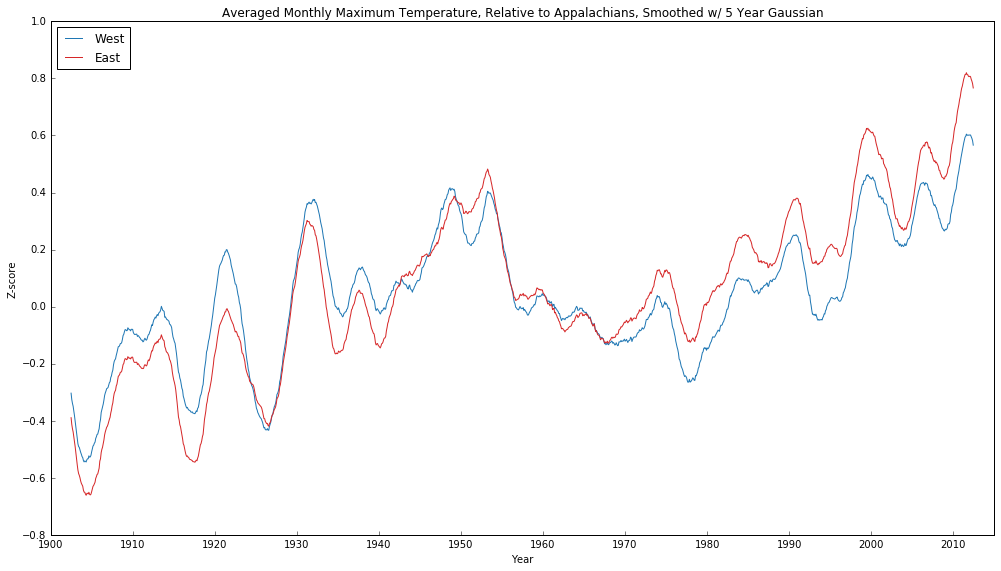

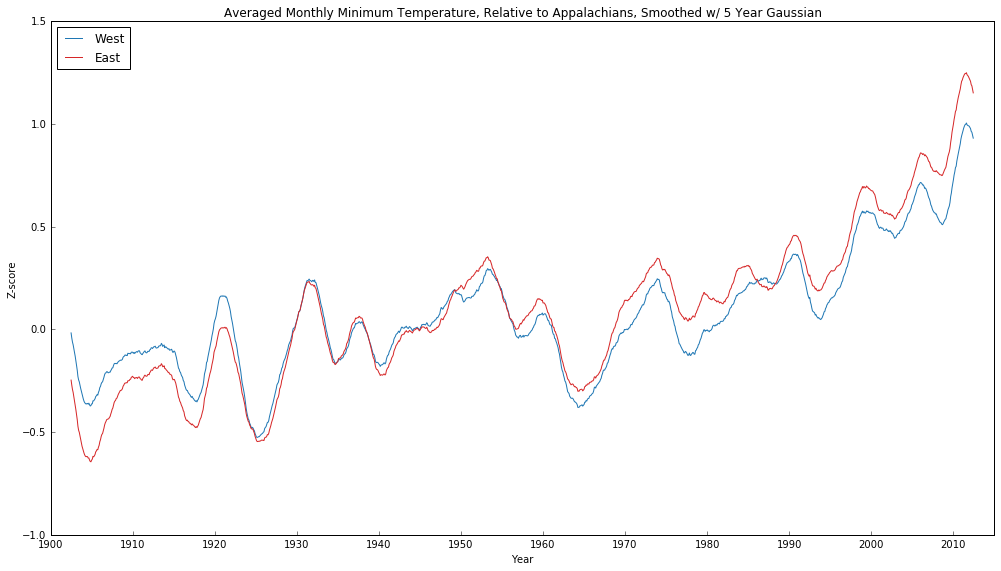

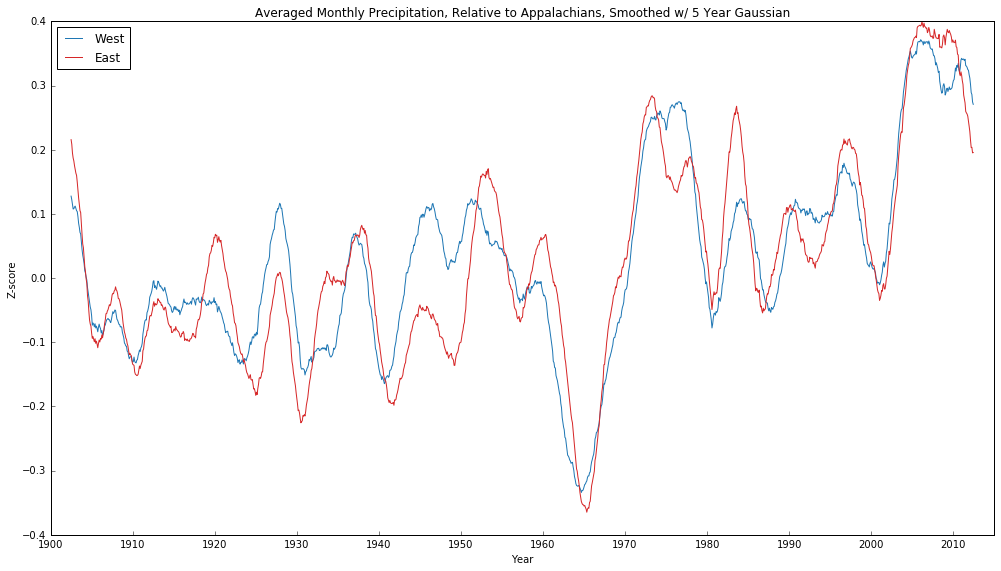

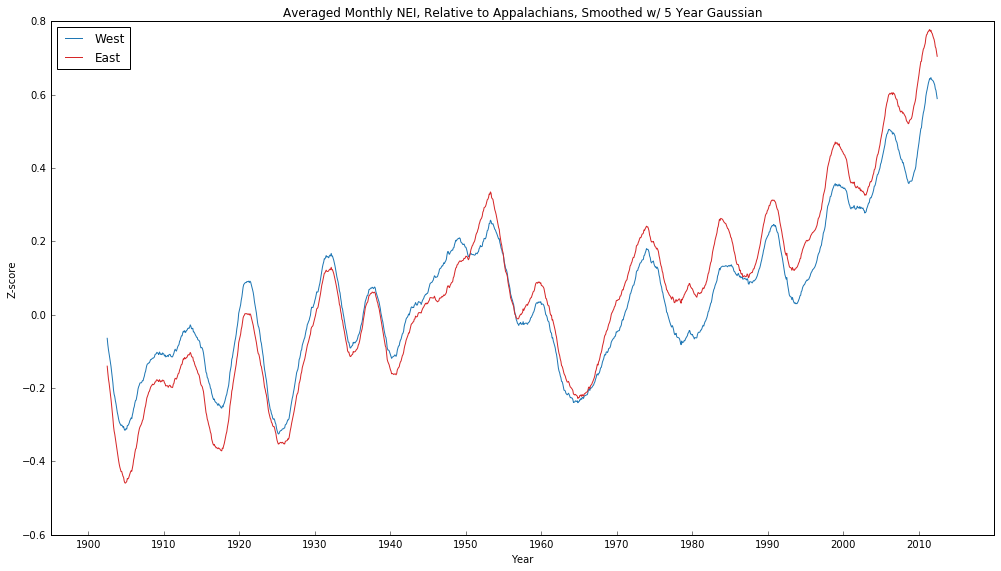

In [19]:
N = 1380
X = np.linspace(1900, 2014+11/12, N, endpoint=True)
kernel_std = 1.25

# max temp timeseries
west_maxtemp_data_smooth = gaussian_smoother(X, west_maxtemp_data, kernel_std)
east_maxtemp_data_smooth = gaussian_smoother(X, east_maxtemp_data, kernel_std)
fig = plt.figure(figsize=(14,8))
ax = plt.subplot(1,1,1)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.xlim(1900, 2015)
plt.xticks(np.arange(1900, 2016, 10))
plt.xlabel("Year")
plt.ylabel("Z-score")
plt.title('Averaged Monthly Maximum Temperature, Relative to Appalachians, Smoothed w/ 5 Year Gaussian')
plt.plot(west_maxtemp_data_smooth[0], west_maxtemp_data_smooth[1], color=tableau20[0])
plt.plot(east_maxtemp_data_smooth[0], east_maxtemp_data_smooth[1], color=tableau20[6])
plt.legend(['West','East'],loc=2)
plt.tight_layout()
plt.show()

# min temp timeseries
west_mintemp_data_smooth = gaussian_smoother(X, west_mintemp_data, kernel_std)
east_mintemp_data_smooth = gaussian_smoother(X, east_mintemp_data, kernel_std)
fig = plt.figure(figsize=(14,8))
ax = plt.subplot(1,1,1)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.xlim(1900, 2015)
plt.xticks(np.arange(1900, 2016, 10))
plt.xlabel("Year")
plt.ylabel("Z-score")
plt.title('Averaged Monthly Minimum Temperature, Relative to Appalachians, Smoothed w/ 5 Year Gaussian')
plt.plot(west_mintemp_data_smooth[0], west_mintemp_data_smooth[1], color=tableau20[0])
plt.plot(east_mintemp_data_smooth[0], east_mintemp_data_smooth[1], color=tableau20[6])
plt.legend(['West','East'],loc=2)
plt.tight_layout()
plt.show()

# precip timeseries
west_precip_data_smooth = gaussian_smoother(X, west_precip_data, kernel_std)
east_precip_data_smooth = gaussian_smoother(X, east_precip_data, kernel_std)
fig = plt.figure(figsize=(14,8))
ax = plt.subplot(1,1,1)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.xlim(1900, 2015)
plt.xticks(np.arange(1900, 2016, 10))
plt.xlabel("Year")
plt.ylabel("Z-score")
plt.title('Averaged Monthly Precipitation, Relative to Appalachians, Smoothed w/ 5 Year Gaussian')
plt.plot(west_precip_data_smooth[0], west_precip_data_smooth[1], color=tableau20[0])
plt.plot(east_precip_data_smooth[0], east_precip_data_smooth[1], color=tableau20[6])
plt.legend(['West','East'],loc=2)
plt.tight_layout()
plt.show()

# nei timeseries
west_nei_data_smooth = gaussian_smoother(X, west_nei_data, kernel_std)
east_nei_data_smooth = gaussian_smoother(X, east_nei_data, kernel_std)
fig = plt.figure(figsize=(14,8))
ax = plt.subplot(1,1,1)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.xlim(1895, 2020)
plt.xticks(np.arange(1900, 2016, 10))
plt.xlabel("Year")
plt.ylabel("Z-score")
plt.title('Averaged Monthly NEI, Relative to Appalachians, Smoothed w/ 5 Year Gaussian')
plt.plot(west_nei_data_smooth[0], west_nei_data_smooth[1], color=tableau20[0])
plt.plot(east_nei_data_smooth[0], east_nei_data_smooth[1], color=tableau20[6])
plt.legend(['West','East'],loc=2)
plt.tight_layout()
plt.show()

### Plotting Wavelet Coefficients of Each Region

In [20]:
# lots of wavelet transforms here
kernel_std = 1.25
kernel_width = 4*kernel_std
scales = scale_range(0.5, 25)
nei_years = scale_range_years(scales, 2*np.pi)
x_list = np.linspace(1900, 2014+11.0/12, 1380, endpoint=True)

# For West Appalachian Stations
# max_temp
start_time = time.perf_counter()
west_maxtemp_transform_coeff = continuous_transform_morlet(west_maxtemp_data, scales, 2*np.pi)
west_maxtemp_transform_power = wavelet_power_spectra(west_maxtemp_transform_coeff)

west_maxtemp_smoothed_wavelet_power = wavelet_power_smoothing(x_list, west_maxtemp_transform_power, kernel_std)
west_maxtemp_smoothed_wavelet_power_x = west_maxtemp_smoothed_wavelet_power[0]
west_maxtemp_smoothed_wavelet_power_coeffs = west_maxtemp_smoothed_wavelet_power[1]
end_time = time.perf_counter()
print("Time Elapsed: "+ str(end_time-start_time))

# min_temp
start_time = time.perf_counter()
west_mintemp_transform_coeff = continuous_transform_morlet(west_mintemp_data, scales, 2*np.pi)
west_mintemp_transform_power = wavelet_power_spectra(west_mintemp_transform_coeff)

west_mintemp_smoothed_wavelet_power = wavelet_power_smoothing(x_list, west_mintemp_transform_power, kernel_std)
west_mintemp_smoothed_wavelet_power_x = west_mintemp_smoothed_wavelet_power[0]
west_mintemp_smoothed_wavelet_power_coeffs = west_mintemp_smoothed_wavelet_power[1]
end_time = time.perf_counter()
print("Time Elapsed: "+ str(end_time-start_time))

# precip
start_time = time.perf_counter()
west_precip_transform_coeff = continuous_transform_morlet(west_precip_data, scales, 2*np.pi)
west_precip_transform_power = wavelet_power_spectra(west_precip_transform_coeff)

west_precip_smoothed_wavelet_power = wavelet_power_smoothing(x_list, west_precip_transform_power, kernel_std)
west_precip_smoothed_wavelet_power_x = west_precip_smoothed_wavelet_power[0]
west_precip_smoothed_wavelet_power_coeffs = west_precip_smoothed_wavelet_power[1]
end_time = time.perf_counter()
print("Time Elapsed: "+ str(end_time-start_time))

# nei
start_time = time.perf_counter()
west_nei_transform_coeff = continuous_transform_morlet(west_nei_data, scales, 2*np.pi)
west_nei_transform_power = wavelet_power_spectra(west_nei_transform_coeff)

west_nei_smoothed_wavelet_power = wavelet_power_smoothing(x_list, west_nei_transform_power, kernel_std)
west_nei_smoothed_wavelet_power_x = west_nei_smoothed_wavelet_power[0]
west_nei_smoothed_wavelet_power_coeffs = west_nei_smoothed_wavelet_power[1]
end_time = time.perf_counter()
print("Time Elapsed: "+ str(end_time-start_time))

# For East Appalacian Stations
# max_temp
start_time = time.perf_counter()
east_maxtemp_transform_coeff = continuous_transform_morlet(east_maxtemp_data, scales, 2*np.pi)
east_maxtemp_transform_power = wavelet_power_spectra(east_maxtemp_transform_coeff)

east_maxtemp_smoothed_wavelet_power = wavelet_power_smoothing(x_list, east_maxtemp_transform_power, kernel_std)
east_maxtemp_smoothed_wavelet_power_x = east_maxtemp_smoothed_wavelet_power[0]
east_maxtemp_smoothed_wavelet_power_coeffs = east_maxtemp_smoothed_wavelet_power[1]
end_time = time.perf_counter()
print("Time Elapsed: "+ str(end_time-start_time))

# min_temp
start_time = time.perf_counter()
east_mintemp_transform_coeff = continuous_transform_morlet(east_mintemp_data, scales, 2*np.pi)
east_mintemp_transform_power = wavelet_power_spectra(east_mintemp_transform_coeff)

east_mintemp_smoothed_wavelet_power = wavelet_power_smoothing(x_list, east_mintemp_transform_power, kernel_std)
east_mintemp_smoothed_wavelet_power_x = east_mintemp_smoothed_wavelet_power[0]
east_mintemp_smoothed_wavelet_power_coeffs = east_mintemp_smoothed_wavelet_power[1]
end_time = time.perf_counter()
print("Time Elapsed: "+ str(end_time-start_time))

# precip
start_time = time.perf_counter()
east_precip_transform_coeff = continuous_transform_morlet(east_precip_data, scales, 2*np.pi)
east_precip_transform_power = wavelet_power_spectra(east_precip_transform_coeff)

east_precip_smoothed_wavelet_power = wavelet_power_smoothing(x_list, east_precip_transform_power, kernel_std)
east_precip_smoothed_wavelet_power_x = east_precip_smoothed_wavelet_power[0]
east_precip_smoothed_wavelet_power_coeffs = east_precip_smoothed_wavelet_power[1]
end_time = time.perf_counter()
print("Time Elapsed: "+ str(end_time-start_time))

# nei
start_time = time.perf_counter()
east_nei_transform_coeff = continuous_transform_morlet(east_nei_data, scales, 2*np.pi)
east_nei_transform_power = wavelet_power_spectra(east_nei_transform_coeff)

east_nei_smoothed_wavelet_power = wavelet_power_smoothing(x_list, east_nei_transform_power, kernel_std)
east_nei_smoothed_wavelet_power_x = east_nei_smoothed_wavelet_power[0]
east_nei_smoothed_wavelet_power_coeffs = east_nei_smoothed_wavelet_power[1]
end_time = time.perf_counter()
print("Time Elapsed: "+ str(end_time-start_time))

Time Elapsed: 2.745940817441037
Time Elapsed: 2.747078884463784
Time Elapsed: 2.744944656592182
Time Elapsed: 2.722463030111774
Time Elapsed: 2.7253728751215416
Time Elapsed: 2.7231720486845745
Time Elapsed: 2.720446374322872
Time Elapsed: 2.7261108384554475


### Maximum Temperature Transformed Data

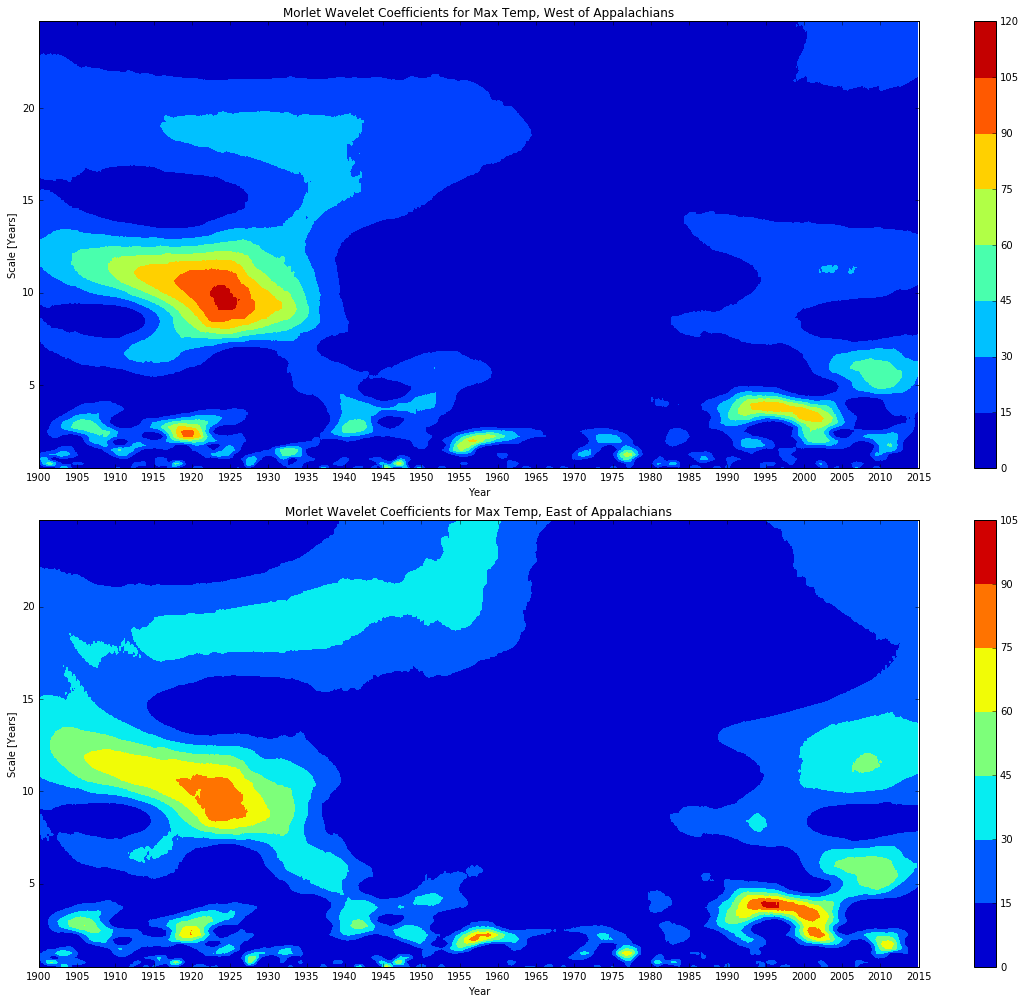

In [21]:
fig = plt.figure(figsize=(16,14))
plt.subplot(2,1,1)
plt.contourf(x_list, nei_years, west_maxtemp_transform_power)
plt.xlabel("Year")
plt.ylabel("Scale [Years]")
plt.xticks(np.arange(1900, 2016, 5))
plt.title("Morlet Wavelet Coefficients for Max Temp, West of Appalachians")
cbar = plt.colorbar()

plt.subplot(2,1,2)
plt.contourf(x_list, nei_years, east_maxtemp_transform_power)
plt.xlabel("Year")
plt.ylabel("Scale [Years]")
plt.xticks(np.arange(1900, 2016, 5))
plt.title("Morlet Wavelet Coefficients for Max Temp, East of Appalachians")
cbar = plt.colorbar()

fig.tight_layout()
plt.show()

### Minimum Temperature Transformed Data

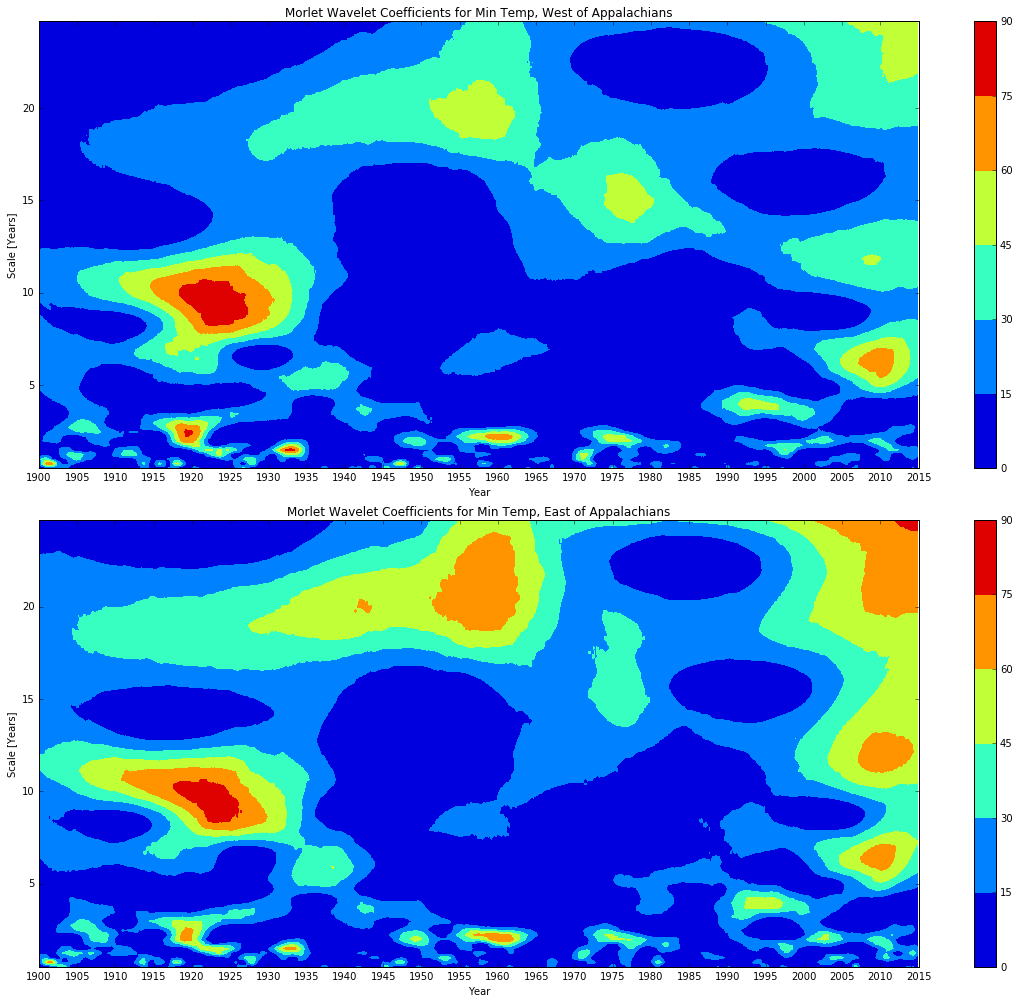

In [22]:
fig = plt.figure(figsize=(16,14))
plt.subplot(2,1,1)
plt.contourf(x_list, nei_years, west_mintemp_transform_power)
plt.xlabel("Year")
plt.ylabel("Scale [Years]")
plt.xticks(np.arange(1900, 2016, 5))
plt.title("Morlet Wavelet Coefficients for Min Temp, West of Appalachians")
cbar = plt.colorbar()

plt.subplot(2,1,2)
plt.contourf(x_list, nei_years, east_mintemp_transform_power)
plt.xlabel("Year")
plt.ylabel("Scale [Years]")
plt.xticks(np.arange(1900, 2016, 5))
plt.title("Morlet Wavelet Coefficients for Min Temp, East of Appalachians")
cbar = plt.colorbar()

fig.tight_layout()
plt.show()

### Precipitation Transformed Data

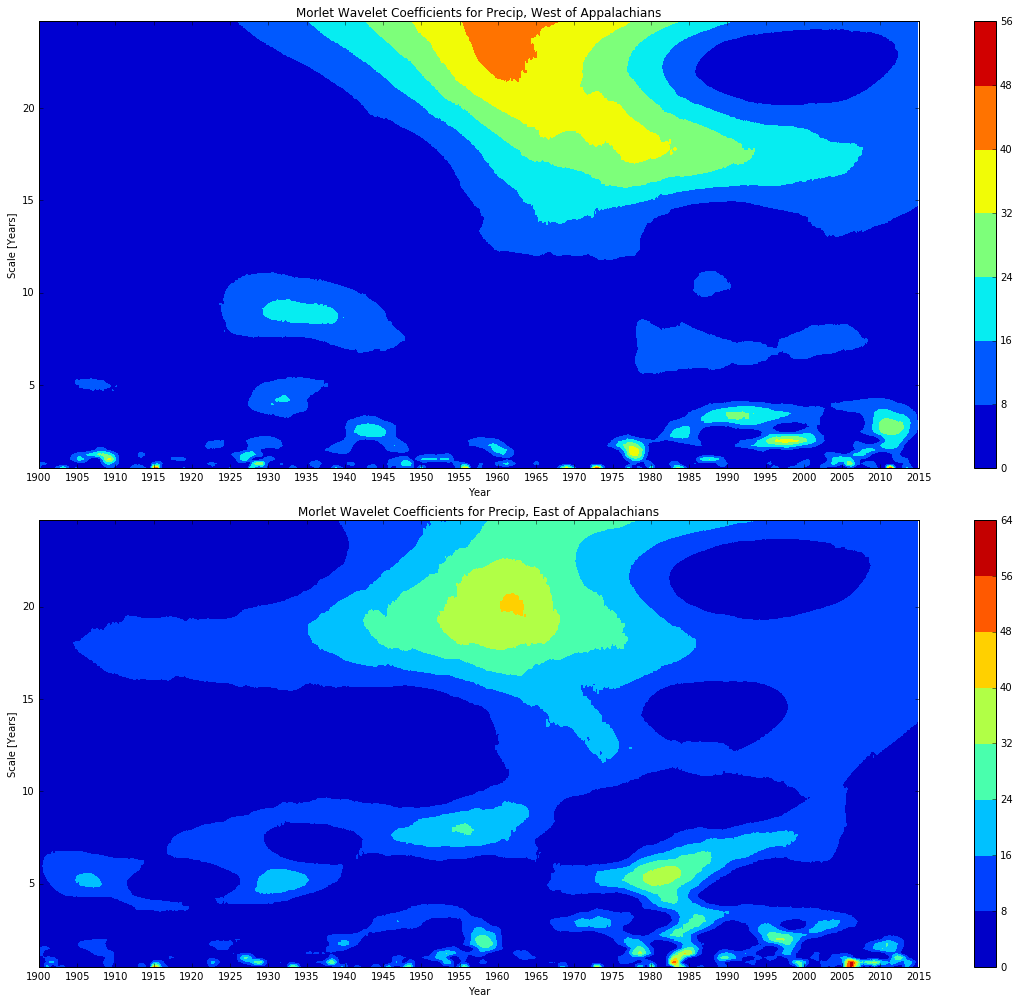

In [23]:
fig = plt.figure(figsize=(16,14))
plt.subplot(2,1,1)
plt.contourf(x_list, nei_years, west_precip_transform_power)
plt.xlabel("Year")
plt.ylabel("Scale [Years]")
plt.xticks(np.arange(1900, 2016, 5))
plt.title("Morlet Wavelet Coefficients for Precip, West of Appalachians")
cbar = plt.colorbar()

plt.subplot(2,1,2)
plt.contourf(x_list, nei_years, east_precip_transform_power)
plt.xlabel("Year")
plt.ylabel("Scale [Years]")
plt.xticks(np.arange(1900, 2016, 5))
plt.title("Morlet Wavelet Coefficients for Precip, East of Appalachians")
cbar = plt.colorbar()

fig.tight_layout()
plt.show()

### NEI Transformed Data

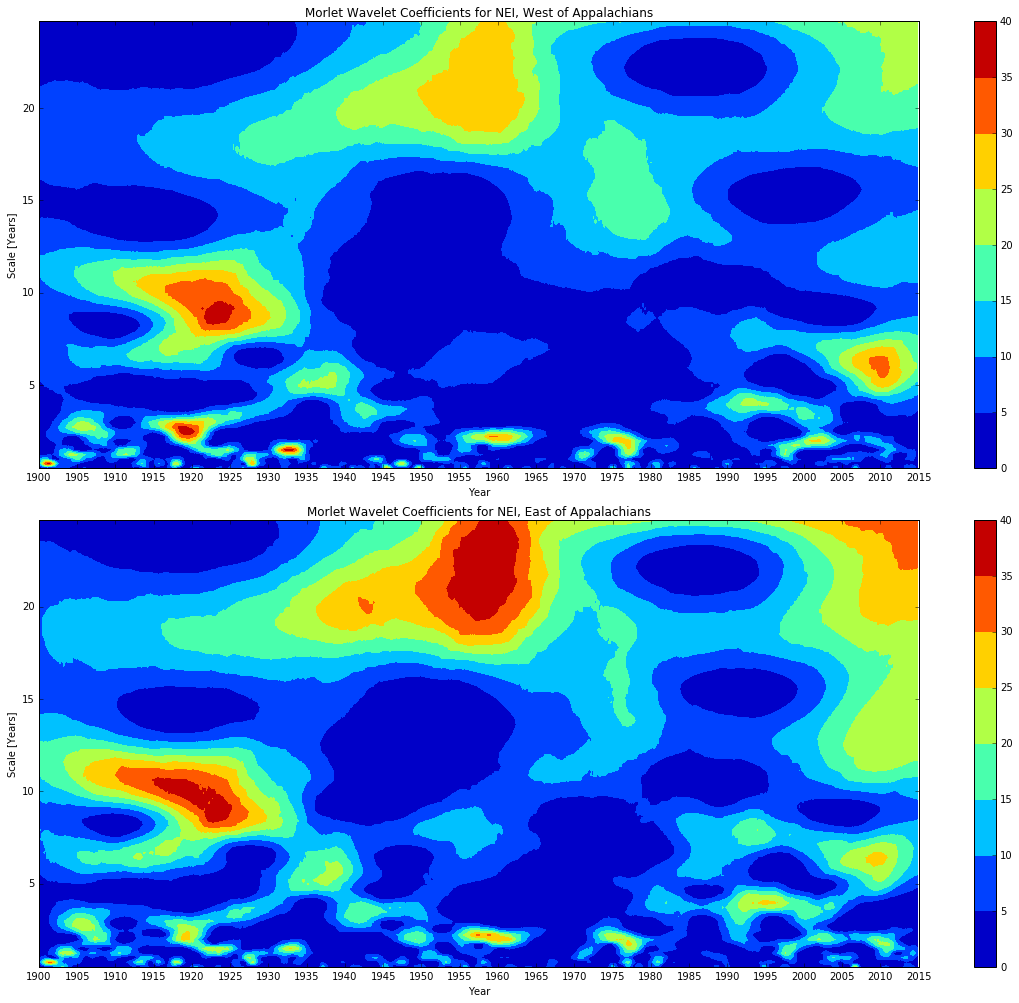

In [24]:
fig = plt.figure(figsize=(16,14))
plt.subplot(2,1,1)
plt.contourf(x_list, nei_years, west_nei_transform_power)
plt.xlabel("Year")
plt.ylabel("Scale [Years]")
plt.xticks(np.arange(1900, 2016, 5))
plt.title("Morlet Wavelet Coefficients for NEI, West of Appalachians")
cbar = plt.colorbar()

plt.subplot(2,1,2)
plt.contourf(x_list, nei_years, east_nei_transform_power)
plt.xlabel("Year")
plt.ylabel("Scale [Years]")
plt.xticks(np.arange(1900, 2016, 5))
plt.title("Morlet Wavelet Coefficients for NEI, East of Appalachians")
cbar = plt.colorbar()

fig.tight_layout()
plt.show()